# Validating fine-tuned Generator via fine-tuned Classifier

In [1]:
# setup 
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pprint
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from tqdm import tqdm
from typing import List, Dict, Any
from datasets import Dataset, concatenate_datasets
import re
import nltk
from nltk.tokenize import sent_tokenize


# load data
generated_speeches_df = pd.read_csv("../data/generated_speeches_final_context.csv")

# rename label CDU/CSU correctly for mapping later
generated_speeches_df["party"] = generated_speeches_df["party"].replace({
    "Union": "CDU/CSU"
})

In [3]:
# seperate dfs per model answers

all_columns_to_predict = ['speech_base_model_01', 
                          'speech_ft_model_01',
                          'speech_base_model_03', 
                          'speech_ft_model_03', 
                          'RAG_speech_01',
                          'RAG_01_context_1', 
                          'RAG_01_context_2', 
                          'RAG_01_context_3',
                          'RAG_speech_03']


data_dict = {}

for column in all_columns_to_predict:
    df = generated_speeches_df[["party", column]].rename(columns={"party": "label", column: "speech_text"})
    data_dict[column] = Dataset.from_pandas(df)

# save single dfs:
speech_base_model_01 = data_dict["speech_base_model_01"]
speech_ft_model_01 = data_dict["speech_ft_model_01"]
speech_base_model_03 = data_dict["speech_base_model_03"]
speech_ft_model_03 = data_dict["speech_ft_model_03"]
RAG_speech_01 = data_dict["RAG_speech_01"]
RAG_01_context_1 = data_dict["RAG_01_context_1"]
RAG_01_context_2 = data_dict["RAG_01_context_2"]
RAG_01_context_3 = data_dict["RAG_01_context_3"]
RAG_speech_03 = data_dict["RAG_speech_03"]


# merging the original speech data into one baseline df
baseline_real_speeches = concatenate_datasets([RAG_01_context_1, RAG_01_context_2, RAG_01_context_3])

In [ ]:
# functions to delete all party mentions
def extract_and_remove_party_mentions(speech_text, party):
    if not isinstance(speech_text, str):
        return [], speech_text

    sentences = sent_tokenize(speech_text, language='german')
    party_lower = party.lower()

    matched = [s for s in sentences if party_lower in s.lower()]
    cleaned = [s for s in sentences if party_lower not in s.lower()]

    cleaned_text = ' '.join(cleaned)
    return matched, cleaned_text


cleaned_data_dict = {}

for name, dataset in data_dict.items():
    # Convert to pandas
    df = dataset.to_pandas()

    # Apply extraction and cleaning
    matches_and_cleaned = df.apply(
        lambda row: extract_and_remove_party_mentions(row["speech_text"], row["label"]), axis=1
    )
    
    # Separate matched and cleaned
    df["matches"] = matches_and_cleaned.apply(lambda x: x[0])
    df["speech_text"] = matches_and_cleaned.apply(lambda x: x[1])

    # Convert back to Hugging Face Dataset
    cleaned_data_dict[name] = Dataset.from_pandas(df)



In [5]:
# load best classifier model

# Load model and tokenizer from local folder
model = AutoModelForSequenceClassification.from_pretrained("../data/windowmodel")
tokenizer = AutoTokenizer.from_pretrained("../data/windowmodel")


/Users/ellaalle/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/ellaalle/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 6): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: /Users/ellaalle/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in: /Users/ellaalle/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib
 in /Users/ellaalle/anaconda3/lib/python3.11/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-08-05 17:52:18.961172: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To en

In [ ]:
# define parameters
WINDOW_LENGTH = 512
STRIDE = 256
label_names = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'AfD', 'LINKE']

In [ ]:
# define functions to tokeize test data and predict test data with fine-tuned model
model.eval()

def tokenize_sliding_windows(example: Dict[str, Any]) -> Dict[str, Any]:
    encoding = tokenizer(
        example["speech_text"],
        truncation=True,
        padding="max_length",
        max_length=WINDOW_LENGTH,
        stride=STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=False,
        return_tensors="pt"
    )
    return encoding

def predict_proba_for_dataset(dataset: Dataset, label_names) -> List[Dict[str, Any]]:
    results = []

    for example in tqdm(dataset):
        tokenized = tokenize_sliding_windows(example)
        input_ids = tokenized["input_ids"].to(model.device)
        attention_mask = tokenized["attention_mask"].to(model.device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

        avg_probs = probs.mean(axis=0)
        results.append({
            "probs": avg_probs.tolist(),
            "label": example["label"] 
        })

    for item in results:
      probs = item["probs"]
      pred_idx = int(np.argmax(probs))
      item["prediction_label"] = label_names[pred_idx]
    return results


In [8]:
# define function to display eval metrics
def get_metrics(true_labels, preds, model_name):
    metrics_summary = {}

    acc = accuracy_score(true_labels, preds)
    bal_acc = balanced_accuracy_score(true_labels, preds)

    precision = precision_score(true_labels, preds, average='macro', zero_division=0)
    recall = recall_score(true_labels, preds, average='macro', zero_division=0)
    f1 = f1_score(true_labels, preds, average='macro', zero_division=0)

    label_order = sorted(set(true_labels).union(set(preds)))
    report = classification_report(true_labels, preds, labels=label_order, zero_division=0)
    metrics_summary[model_name] = {
        'acc': acc,
        'bal_acc': bal_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    # print metrics
    print(f"Model: {model_name}")
    print(f"  Accuracy: {acc}")
    print(f"  Balanced Accuracy: {bal_acc}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}")
    print(f"  Classification Report:\n{report}")


    # Confusion Matrix
    label_order = sorted(set(true_labels).union(set(preds)))
    cm = confusion_matrix(true_labels, preds, labels=label_order)
    cm_df = pd.DataFrame(cm, index=label_order, columns=label_order)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


    return metrics_summary



In [ ]:
# predict all generated test speeches
all_models_to_test = [speech_base_model_01, 
                        speech_ft_model_01,
                        speech_base_model_03, 
                        speech_ft_model_03, 
                        RAG_speech_01,
                        RAG_speech_03,
                        baseline_real_speeches]

model_names = ['speech_base_model_01', 
                'speech_ft_model_01',
                'speech_base_model_03', 
                'speech_ft_model_03', 
                'RAG_speech_01',
                'RAG_speech_03',
                'baseline_real_speeches']


all_results = {}
i = 0
for dataset_to_predict in all_models_to_test:
    all_results[model_names[i]] = predict_proba_for_dataset(dataset_to_predict, sorted(label_names))
    i += 1



100%|██████████| 72/72 [02:30<00:00,  2.09s/it]


Model: speech_base_model_01
  Accuracy: 0.20833333333333334
  Balanced Accuracy: 0.20833333333333334
  Precision: 0.14351851851851852
  Recall: 0.20833333333333334
  F1-score: 0.1673076923076923
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.00      0.00      0.00         4
     CDU/CSU       0.50      0.75      0.60         4
         FDP       0.25      0.25      0.25         4
       GRÜNE       0.11      0.25      0.15         4
       LINKE       0.00      0.00      0.00         4
         SPD       0.00      0.00      0.00         4

    accuracy                           0.21        24
   macro avg       0.14      0.21      0.17        24
weighted avg       0.14      0.21      0.17        24



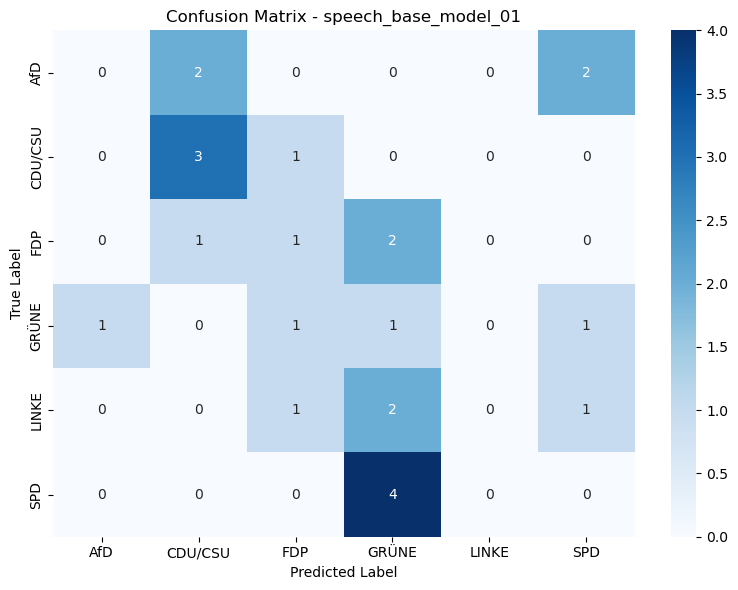

Model: speech_ft_model_01
  Accuracy: 0.20833333333333334
  Balanced Accuracy: 0.20833333333333334
  Precision: 0.17453703703703705
  Recall: 0.20833333333333334
  F1-score: 0.17165242165242164
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.22      0.50      0.31         4
     CDU/CSU       0.00      0.00      0.00         4
         FDP       0.50      0.25      0.33         4
       GRÜNE       0.12      0.25      0.17         4
       LINKE       0.00      0.00      0.00         4
         SPD       0.20      0.25      0.22         4

    accuracy                           0.21        24
   macro avg       0.17      0.21      0.17        24
weighted avg       0.17      0.21      0.17        24



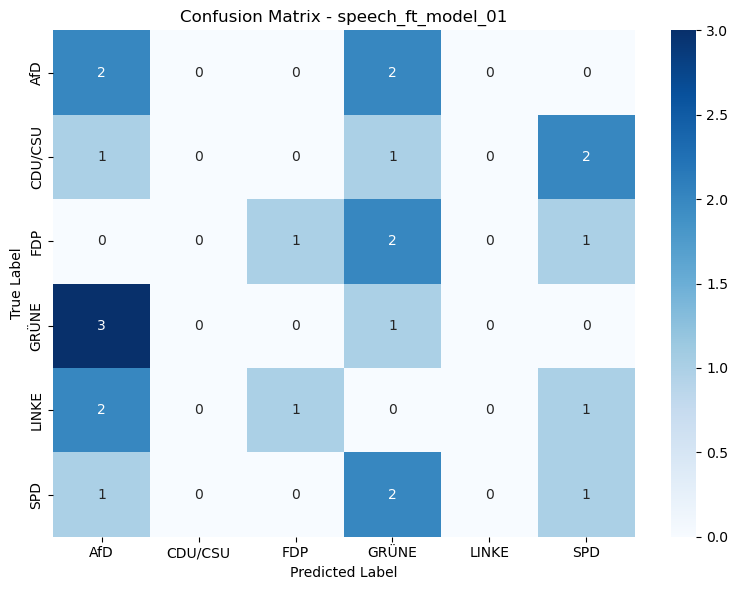

Model: speech_base_model_03
  Accuracy: 0.125
  Balanced Accuracy: 0.125
  Precision: 0.10714285714285714
  Recall: 0.125
  F1-score: 0.0925925925925926
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.50      0.25      0.33         4
     CDU/CSU       0.00      0.00      0.00         4
         FDP       0.00      0.00      0.00         4
       GRÜNE       0.14      0.50      0.22         4
       LINKE       0.00      0.00      0.00         4
         SPD       0.00      0.00      0.00         4

    accuracy                           0.12        24
   macro avg       0.11      0.12      0.09        24
weighted avg       0.11      0.12      0.09        24



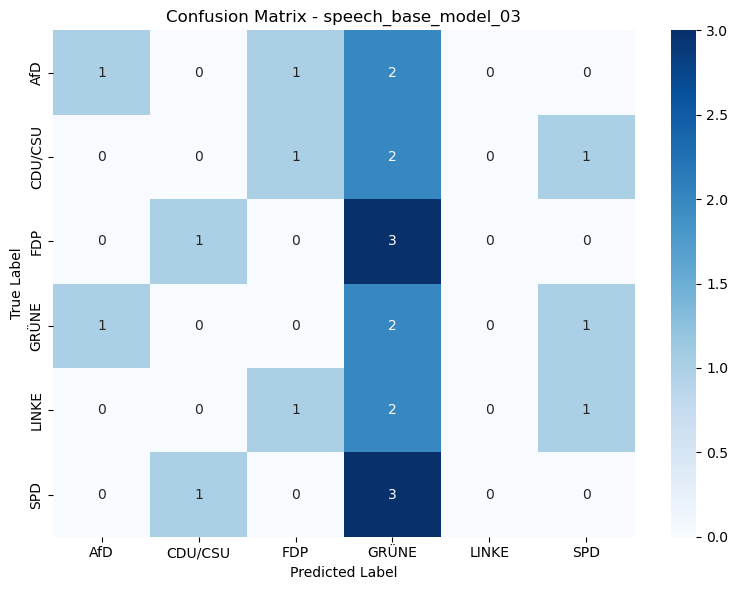

Model: speech_ft_model_03
  Accuracy: 0.25
  Balanced Accuracy: 0.25
  Precision: 0.14682539682539683
  Recall: 0.25
  F1-score: 0.16984126984126982
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.33      0.50      0.40         4
     CDU/CSU       0.00      0.00      0.00         4
         FDP       0.33      0.25      0.29         4
       GRÜNE       0.21      0.75      0.33         4
       LINKE       0.00      0.00      0.00         4
         SPD       0.00      0.00      0.00         4

    accuracy                           0.25        24
   macro avg       0.15      0.25      0.17        24
weighted avg       0.15      0.25      0.17        24



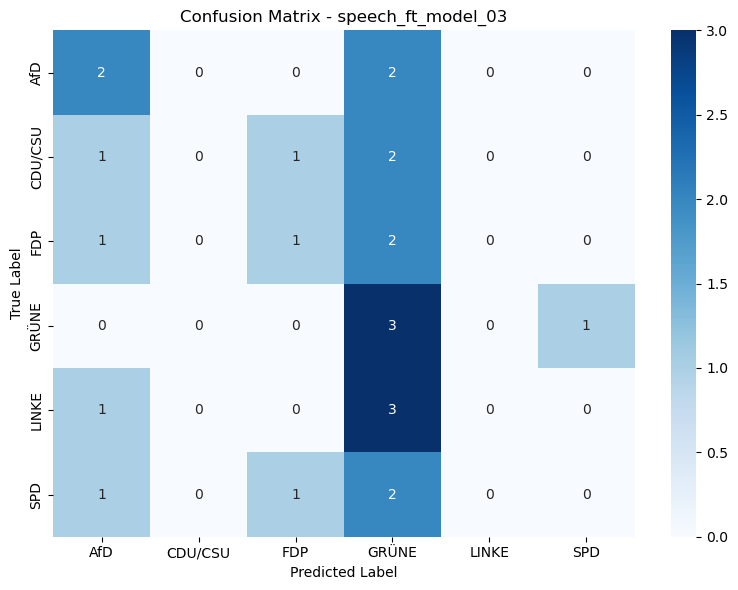

Model: RAG_speech_01
  Accuracy: 0.125
  Balanced Accuracy: 0.125
  Precision: 0.11363636363636365
  Recall: 0.125
  F1-score: 0.09999999999999999
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.00      0.00      0.00         4
     CDU/CSU       0.00      0.00      0.00         4
         FDP       0.50      0.25      0.33         4
       GRÜNE       0.18      0.50      0.27         4
       LINKE       0.00      0.00      0.00         4
         SPD       0.00      0.00      0.00         4

    accuracy                           0.12        24
   macro avg       0.11      0.12      0.10        24
weighted avg       0.11      0.12      0.10        24



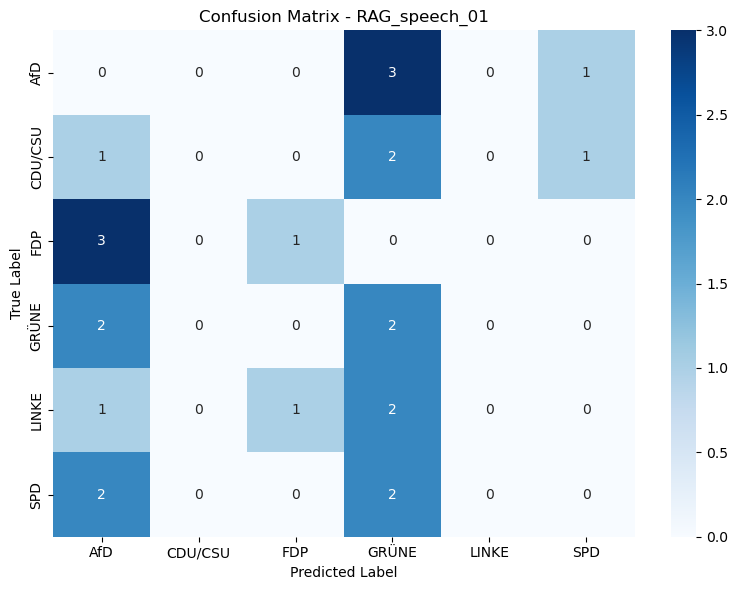

Model: RAG_speech_03
  Accuracy: 0.16666666666666666
  Balanced Accuracy: 0.16666666666666666
  Precision: 0.13278388278388278
  Recall: 0.16666666666666666
  F1-score: 0.12507427213309566
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.14      0.25      0.18         4
     CDU/CSU       0.00      0.00      0.00         4
         FDP       0.50      0.25      0.33         4
       GRÜNE       0.15      0.50      0.24         4
       LINKE       0.00      0.00      0.00         4
         SPD       0.00      0.00      0.00         4

    accuracy                           0.17        24
   macro avg       0.13      0.17      0.13        24
weighted avg       0.13      0.17      0.13        24



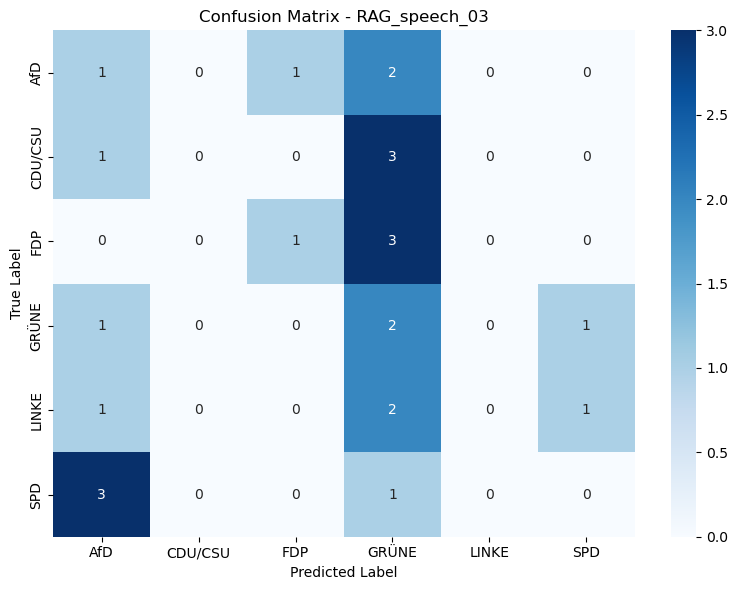

Model: baseline_real_speeches
  Accuracy: 0.7638888888888888
  Balanced Accuracy: 0.763888888888889
  Precision: 0.7947691197691199
  Recall: 0.763888888888889
  F1-score: 0.7626646237058136
  Classification Report:
              precision    recall  f1-score   support

         AfD       1.00      0.58      0.74        12
     CDU/CSU       0.67      1.00      0.80        12
         FDP       0.91      0.83      0.87        12
       GRÜNE       0.75      0.75      0.75        12
       LINKE       0.80      0.67      0.73        12
         SPD       0.64      0.75      0.69        12

    accuracy                           0.76        72
   macro avg       0.79      0.76      0.76        72
weighted avg       0.79      0.76      0.76        72



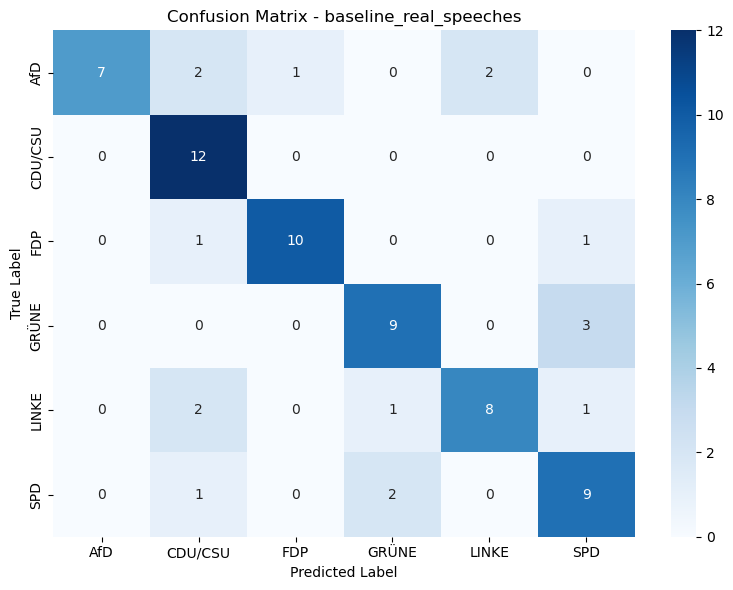

In [10]:
# run get_metrics function on all and save results 
final_performance_results = {}
i = 0

for i in range(len(model_names)):
    df = pd.DataFrame(all_results[model_names[i]])
    results =  get_metrics(df["label"], df["prediction_label"], model_names[i])
    final_performance_results.update(results)
    i += 1


In [11]:
# compare final results
final_performance_results_df = pd.DataFrame(final_performance_results)
final_performance_results_df

,speech_base_model_01,speech_ft_model_01,speech_base_model_03,speech_ft_model_03,RAG_speech_01,RAG_speech_03,baseline_real_speeches
acc,0.208333,0.208333,0.125000,0.250000,0.125000,0.166667,0.763889
bal_acc,0.208333,0.208333,0.125000,0.250000,0.125000,0.166667,0.763889
precision,0.143519,0.174537,0.107143,0.146825,0.113636,0.132784,0.794769
recall,0.208333,0.208333,0.125000,0.250000,0.125000,0.166667,0.763889
f1,0.167308,0.171652,0.092593,0.169841,0.100000,0.125074,0.762665


In [12]:
# Visualising the results
def visualising_results(metrics_summary, results_dict = model_names):
    """Producing comprehensive visualisation that works with any number of models"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    model_names = results_dict
    num_models = len(model_names)

    accuracies = [metrics_summary[name]['acc'] for name in model_names]
    balanced_accuracies = [metrics_summary[name]['bal_acc'] for name in model_names]
    precisions = [metrics_summary[name]['precision'] for name in model_names]
    recalls = [metrics_summary[name]['recall'] for name in model_names]
    f1_scores = [metrics_summary[name]['f1'] for name in model_names]

    # Subplot 1: Accuracy
    axes[0, 0].bar(np.arange(num_models) - 0.2, accuracies, width=0.4, label='Accuracy', color='skyblue')
    axes[0, 0].bar(np.arange(num_models) + 0.2, balanced_accuracies, width=0.4, label='Balanced Accuracy', color='lightgreen')
    axes[0, 0].set_title('Accuracy Comparison')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_xticks(np.arange(num_models))
    axes[0, 0].set_xticklabels(model_names, rotation=45)
    axes[0, 0].legend()

    # Subplot 2: Precision and Recall
    width = 0.35
    x = np.arange(num_models)
    axes[0, 1].bar(x - width/2, precisions, width, label='Precision', alpha=0.7, color='orange')
    axes[0, 1].bar(x + width/2, recalls, width, label='Recall', alpha=0.7, color='red')
    axes[0, 1].set_title('Precision and Recall')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(model_names, rotation=45)
    axes[0, 1].legend()

    # Subplot 3: F1
    axes[1, 0].bar(model_names, f1_scores, alpha=0.7, color='purple')
    axes[1, 0].set_title('F1 Score Comparison')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Subplot 4: Overall Performance Comparison
    metrics = ['Exact Acc', 'Partial Acc', 'Precision', 'Recall', 'F1']
    for idx, name in enumerate(model_names):
        model_scores = [
            accuracies[idx],
            balanced_accuracies[idx],
            precisions[idx],
            recalls[idx],
            f1_scores[idx],
        ]
        marker = ['o', 's', '^', 'D', 'x'][idx % 5]  # Use different markers
        axes[1, 1].plot(metrics, model_scores, marker + '-', label=name, linewidth=2, markersize=8)

    axes[1, 1].set_title('Overall Performance Comparison')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].legend()
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


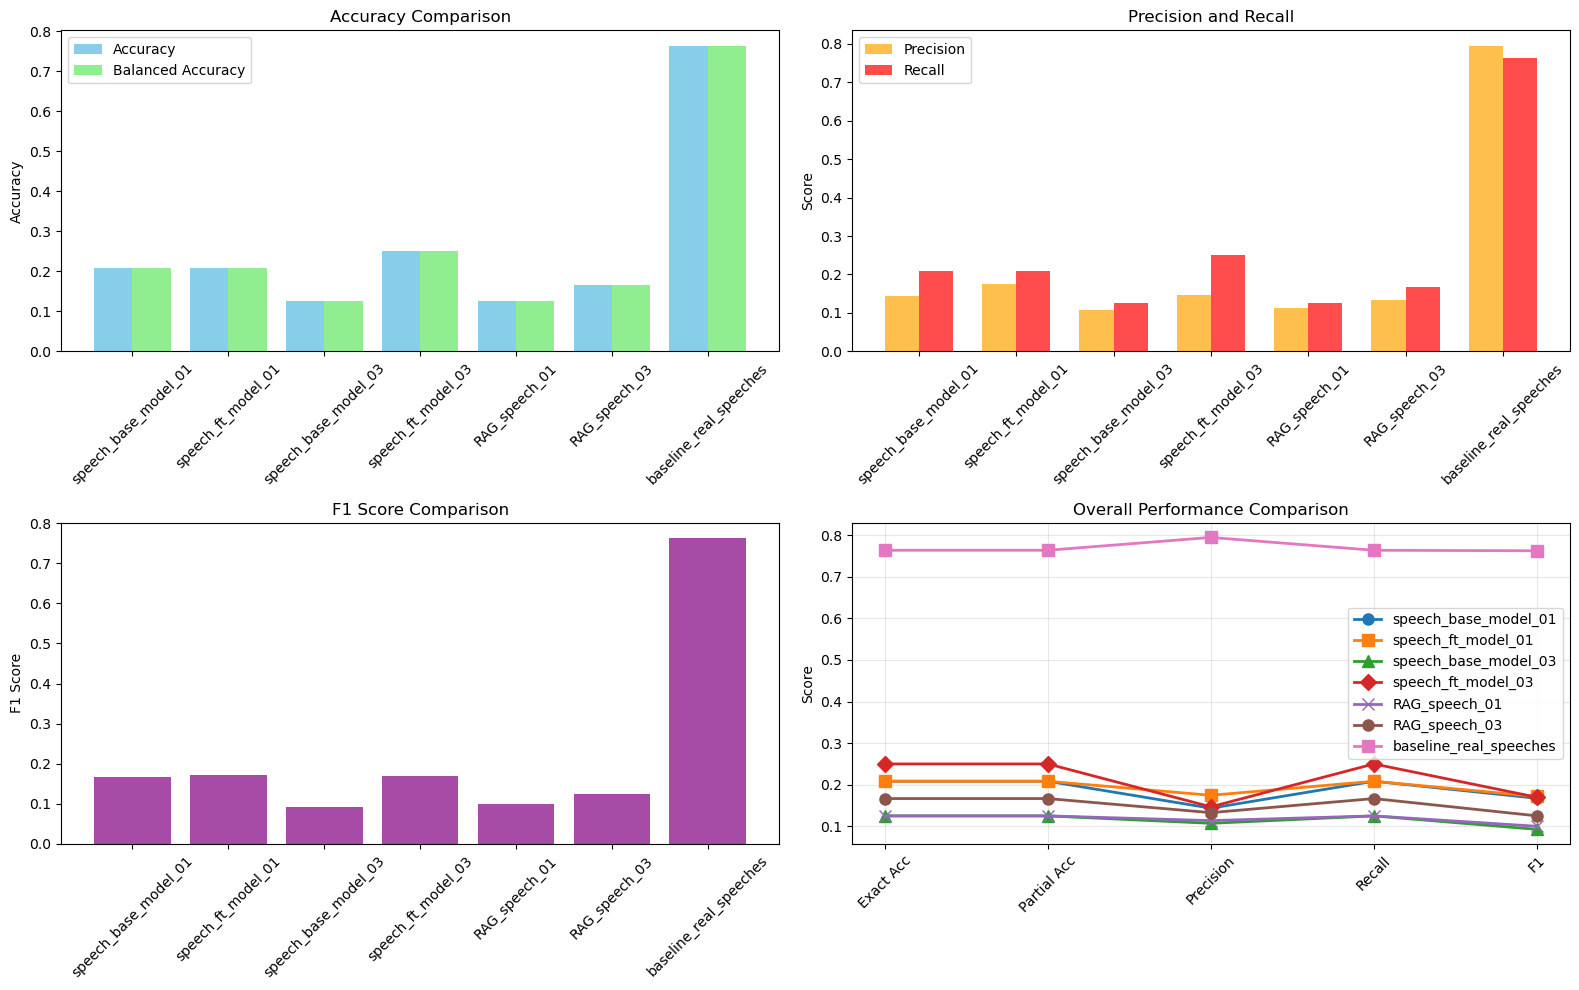

In [32]:
visualising_results(final_performance_results, results_dict = model_names)